## Predicting drive failure with XGBoost and RAPIDS

**Dataset**: Hard disk SMART data and failure dataset from Backblaze ([More information](https://www.backblaze.com/b2/hard-drive-test-data.html))

**Task**: Predict hard disk failure with RAPIDS

In [1]:
import time
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

from sklearn.metrics import *
import matplotlib.pyplot as plt
%matplotlib inline

# RAPIDS
import cudf
import xgboost as xgb

In [2]:
# download our training and evaluation data
!wget -nc https://s3-ap-southeast-1.amazonaws.com/deeplearning-mat/hdd_test_data/train.csv
!wget -nc https://s3-ap-southeast-1.amazonaws.com/deeplearning-mat/hdd_test_data/eval.csv

File ‘train.csv’ already there; not retrieving.

File ‘eval.csv’ already there; not retrieving.



### 1. Load Data

#### Training Data

Use Pandas to load training data from CSV. This consists of the pre-processed drive data from **January 2015** to **September 2018**.

In [3]:
df = pd.read_csv("train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16770 entries, 0 to 16769
Columns: 318 entries, failure to feat314
dtypes: float64(315), int64(3)
memory usage: 40.7 MB


Split into features (`df_train`) and labels(`df_target`), where each is a Pandas `Dataframe`.

In [4]:
df_train = df.drop(["failure"],axis=1).apply(pd.to_numeric).astype(np.float32)
df_train_target = pd.DataFrame(df["failure"]).apply(pd.to_numeric)

#### Evaluation Data

Do the same thing to load evaluation data from CSV.

In our case, this consists of the pre-processed drive data from **October 2018 to December 2018**.

In [5]:
df_t = pd.read_csv("eval.csv")
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4527 entries, 0 to 4526
Columns: 318 entries, failure to feat314
dtypes: float64(315), int64(3)
memory usage: 11.0 MB


In [6]:
df_test = df_t.drop(["failure"],axis=1).apply(pd.to_numeric).astype(np.float32)
df_test_target = pd.DataFrame(df_t["failure"]).apply(pd.to_numeric)

### 2. Model Parameters

In [7]:
MAX_TREE_DEPTH = 10
TREE_METHOD = 'hist'
ITERATIONS = 120
SUBSAMPLE = 0.8
REGULARIZATION = 1.4
GAMMA = 0.4
POS_WEIGHT = 0.8
EARLY_STOP = None

### 3. Train with CPU

XGBoost training with CPU (`params[tree_method] = 'hist'`), using a Pandas `Dataframe` loaded into `xgb.DMatrix`. For more information, check out [this page in the XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/python/python_intro.html).

As we can see, training with even a high-end Intel Xeon CPU is pretty slow!

In [8]:
!lscpu | grep 'Model name:'
!lscpu | grep 'CPU(s)'

Model name:          Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz
CPU(s):              40
On-line CPU(s) list: 0-39
NUMA node0 CPU(s):   0-39


In [9]:
start_time = time.time()

xgtrain = xgb.DMatrix(df_train, df_train_target)
xgeval = xgb.DMatrix(df_test, df_test_target)

params = {'tree_method': TREE_METHOD, 'max_depth': MAX_TREE_DEPTH, 'alpha': REGULARIZATION,
          'gamma': GAMMA, 'subsample': SUBSAMPLE, 'scale_pos_weight': POS_WEIGHT, 'learning_rate': 0.05, 'silent': 1}

bst = xgb.train(params, xgtrain, ITERATIONS, evals=[(xgtrain, "train"), (xgeval, "eval")],
                early_stopping_rounds=EARLY_STOP)

timetaken_cpu = time.time() - start_time

# free up memory
del xgtrain
del bst

[0]	train-rmse:0.484645	eval-rmse:0.482874
[1]	train-rmse:0.470413	eval-rmse:0.466816
[2]	train-rmse:0.457102	eval-rmse:0.452582
[3]	train-rmse:0.444752	eval-rmse:0.437972
[4]	train-rmse:0.433335	eval-rmse:0.42463
[5]	train-rmse:0.422742	eval-rmse:0.412813
[6]	train-rmse:0.412927	eval-rmse:0.401007
[7]	train-rmse:0.403715	eval-rmse:0.390577
[8]	train-rmse:0.395206	eval-rmse:0.380392
[9]	train-rmse:0.387268	eval-rmse:0.37212
[10]	train-rmse:0.37999	eval-rmse:0.362625
[11]	train-rmse:0.373443	eval-rmse:0.353973
[12]	train-rmse:0.367512	eval-rmse:0.346046
[13]	train-rmse:0.36188	eval-rmse:0.338827
[14]	train-rmse:0.356754	eval-rmse:0.331773
[15]	train-rmse:0.352014	eval-rmse:0.32522
[16]	train-rmse:0.347603	eval-rmse:0.319345
[17]	train-rmse:0.343501	eval-rmse:0.313636
[18]	train-rmse:0.339799	eval-rmse:0.308468
[19]	train-rmse:0.336476	eval-rmse:0.303938
[20]	train-rmse:0.333339	eval-rmse:0.299364
[21]	train-rmse:0.330495	eval-rmse:0.296466
[22]	train-rmse:0.327894	eval-rmse:0.293518
[23

In [10]:
print("CPU Time Taken:\n", round(timetaken_cpu,1))

CPU Time Taken:
 10.2


### 4. Train with GPU

To use GPU, we set `params[tree_method] = 'gpu_hist'`. Use full RAPIDS stack by using XGBoost with cuDF for additional speedup. To do this, we load the Pandas `Dataframe` into a cuDF Dataframe (Python object type `cudf.dataframe.dataframe.DataFrame`).

In [11]:
# load into cuDF Dataframe

gdf_train = cudf.DataFrame.from_pandas(df_train)
gdf_train_target = cudf.DataFrame.from_pandas(df_train_target)

gdf_eval = cudf.DataFrame.from_pandas(df_test)
gdf_eval_target = cudf.DataFrame.from_pandas(df_test_target)

print("Moved data to GPU")

Moved data to GPU


In [12]:
# GPU, with using cuDF

start_time = time.time()

xgtrain = xgb.DMatrix(gdf_train, gdf_train_target)
xgeval = xgb.DMatrix(gdf_eval, gdf_eval_target)

params = {'tree_method': "gpu_"+TREE_METHOD, 'max_depth': MAX_TREE_DEPTH, 'alpha': REGULARIZATION,
          'gamma': GAMMA, 'subsample': SUBSAMPLE, 'scale_pos_weight': POS_WEIGHT, 'learning_rate': 0.05, 'silent': 1}

bst = xgb.train(params, xgtrain, ITERATIONS, evals=[(xgtrain, "train"), (xgeval, "eval")],
                early_stopping_rounds=EARLY_STOP)

timetaken_gpu = time.time() - start_time

[0]	train-rmse:0.484501	eval-rmse:0.482816
[1]	train-rmse:0.470061	eval-rmse:0.466884
[2]	train-rmse:0.456755	eval-rmse:0.452751
[3]	train-rmse:0.444308	eval-rmse:0.438795
[4]	train-rmse:0.432728	eval-rmse:0.42489
[5]	train-rmse:0.421823	eval-rmse:0.413768
[6]	train-rmse:0.411802	eval-rmse:0.402158
[7]	train-rmse:0.402525	eval-rmse:0.391624
[8]	train-rmse:0.393929	eval-rmse:0.383041
[9]	train-rmse:0.386055	eval-rmse:0.373432
[10]	train-rmse:0.378609	eval-rmse:0.364608
[11]	train-rmse:0.37174	eval-rmse:0.356131
[12]	train-rmse:0.365554	eval-rmse:0.34843
[13]	train-rmse:0.359738	eval-rmse:0.342121
[14]	train-rmse:0.354517	eval-rmse:0.336471
[15]	train-rmse:0.349668	eval-rmse:0.329685
[16]	train-rmse:0.34512	eval-rmse:0.323881
[17]	train-rmse:0.340924	eval-rmse:0.318932
[18]	train-rmse:0.337105	eval-rmse:0.313837
[19]	train-rmse:0.333627	eval-rmse:0.309053
[20]	train-rmse:0.330345	eval-rmse:0.304334
[21]	train-rmse:0.327122	eval-rmse:0.299846
[22]	train-rmse:0.324215	eval-rmse:0.296158
[2

In [13]:
print("Check GPU memory usage")
!gpustat

Check GPU memory usage
f374927f9fc6  Wed Apr 17 16:56:28 2019
[0] Tesla V100-DGXS-16GB | 41'C,   0 % |  1014 / 16125 MB |
[1] Tesla V100-DGXS-16GB | 41'C,   0 % |    12 / 16128 MB |
[2] Tesla V100-DGXS-16GB | 42'C,   0 % |    12 / 16128 MB |
[3] Tesla V100-DGXS-16GB | 41'C,   0 % |    12 / 16128 MB |


### 5. Results

We see a significant speed-up when we use the RAPIDS stack.

In [14]:
print("CPU Time Taken:\n", round(timetaken_cpu,1))
print("\nGPU + cuDF Time Taken:\n", round(timetaken_gpu,1))
print("\nTotal speed-up with RAPIDS:\n", round(timetaken_cpu/timetaken_gpu*100,1), "%")

CPU Time Taken:
 10.2

GPU + cuDF Time Taken:
 2.4

Total speed-up with RAPIDS:
 428.0 %


Let's look at the model's performance on the evalutation set

In [15]:
preds = bst.predict(xgeval)

y_pred = []

THRESHOLD = 0.5

for pred in preds:
    if pred<=THRESHOLD:
        y_pred.append(0)
    if pred>THRESHOLD:
        y_pred.append(1)

y_pred = np.asarray(y_pred)
        
y_true = df_test_target.values.reshape(len(preds))

In [16]:
print("Accuracy (Eval)", round(accuracy_score(y_true, y_pred),3))

Accuracy (Eval) 0.947


In [17]:
print(classification_report(y_true, y_pred, target_names=["normal", "fail"]))

              precision    recall  f1-score   support

      normal       0.97      0.97      0.97      4208
        fail       0.63      0.61      0.62       319

   micro avg       0.95      0.95      0.95      4527
   macro avg       0.80      0.79      0.79      4527
weighted avg       0.95      0.95      0.95      4527



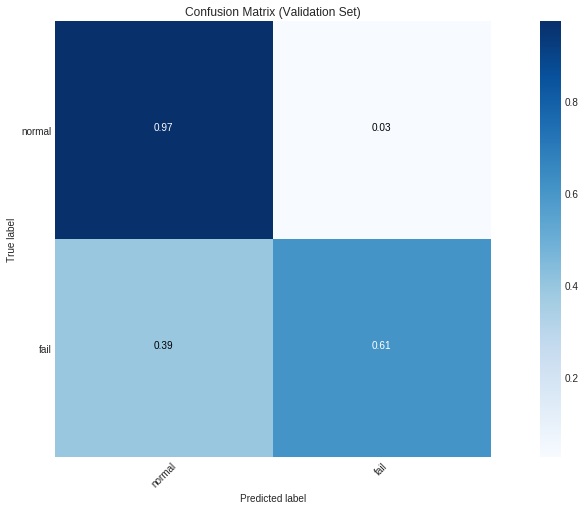

In [18]:
plt.style.use('seaborn-dark')
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(14,7))
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, labels=["normal", "fail"])